In [227]:
import os

from typing import Tuple, Dict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
import missingno as msno

import optuna

from sklearn.base import BaseEstimator
from sklearn.compose import (
    ColumnTransformer,
    make_column_transformer)
from sklearn.pipeline import (
    Pipeline,
    make_pipeline
)
from sklearn.ensemble import (
    IsolationForest,
    RandomForestClassifier
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import (
    learning_curve,
    cross_validate,
    cross_val_score,
)                                    
from sklearn.decomposition import PCA
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'
tqdm.pandas()
plt.style.use('ggplot')

In [18]:
data = pd.read_csv('train.csv')

In [19]:
data.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [20]:
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 140700 │ │ string      │ 10    │                                                          │
│ │ Number of columns │ 20     │ │ float64     │ 8     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name         ┃ NA      ┃ NA %   ┃ mean   ┃ sd     ┃ p0   ┃ p25   ┃ p50   ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ id                  │       0 │      0 │  70350 │  40620 │    0 │ 35170 │ 70350 │ 105500 │ 140700 │ ▇▇▇▇▇▇ │  │
│ │ Age                 │       0 │      0 │  40.39 │  12.38 │   18 │    29 │    42 │     51 │     60 │ ▆▅▅▆▇▇ │  │
│ │ Academic Pressure   │  112803 │  80.17 │  3.142 │   1.38 │    1 │     2 │     3 │      4 │      5 │ ▅▅ ▇▆▇ │  │
│ │ Work Pressure       │   27918 │  19.84 │  2.999 │  1.406 │    1 │     2 │     3 │      4 │      5 │ ▇▇ ▇▇▇ │  │
│ │ CGPA                │  112802 │  80.17 │  7.659 │  1.464 │ 5.03 │  6.29 │  7.77 │   8.92 │     10 │ ▇▅▇▇▇▇ │  │
│ │ Study Satisfaction  │  112803 │  80.17 │  2.945 │   1.36 │    1 │     2 │     3 │      4 │      5 │ ▇▇ ▇▇▆ │  │
│ │ Job Satisfaction    │   27910 │  19.84 │  2.974 │  1.416 │    1 │     2 │     3 │      4 │      5 │ ▇▇ ▇▇▇ │  │
│ │ Work/Study Hours    │       0 │      0 │  6.253 │  3.854 │    0 │     3 │     6 │     10 │     12 │ ▅▅▃▅▅▇ │  │
│ │ Financial Stress    │       4 │      0 │  2.989 │  1.414 │    1 │     2 │     3 │      4 │      5 │ ▇▇ ▇▇▇ │  │
│ │ Depression          │       0 │      0 │ 0.1817 │ 0.3856 │    0 │     0 │     0 │      0 │      1 │ ▇    ▂ │  │
│ └─────────────────────┴─────────┴────────┴────────┴────────┴──────┴───────┴───────┴────────┴────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA         ┃ NA %       ┃ words per row          ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Name                               │          0 │          0 │                      1 │             140702 │  │
│ │ Gender                             │          0 │          0 │                      1 │             140700 │  │
│ │ City                               │          0 │          0 │                      1 │             140704 │  │
│ │ Working Professional or Student    │          0 │          0 │                    1.8 │             253499 │  │
│ │ Profession                         │      36630 │      26.03 │                      1 │             144073 │  │
│ │ Sleep Duration                     │          0 │          0 │                      3 │             424406 │  │
│ │ Dietary Habits                     │          4 │   

In [21]:
data = data.drop(['id', 'Name'], axis=1)

In [125]:
def plot_target_distribution(df: pd.DataFrame,
                             target: str) -> None:
    """
    Plot the distribution of the target variable.

    :param df: The dataset.
    :param target: The target variable.
    """

    df[target].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=[0, 0.1])
    plt.ylabel('')
    plt.title('Target distribution')
    plt.show()

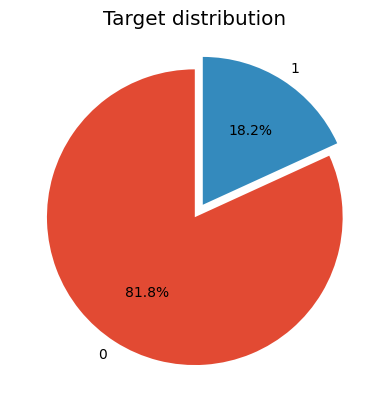

In [126]:
TARGET_COL = 'Depression'
plot_target_distribution(data, TARGET_COL)

In [40]:
def plot_categorical_hist(df: pd.DataFrame,
                          col: str,
                          ax: plt.Axes) -> None:
    """
    Plot the histogram of a categorical column in a specific axis.

    :param df: The dataframe to plot.
    :param col: The column to plot.
    :param ax: The axis to plot the histogram.
    """

    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(f'{col} distribution')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

def plot_categorical_hist(df: pd.DataFrame,
                          col: str,
                          ax: plt.Axes) -> None:
    """
    Plot the histogram of a categorical column in a specific axis.

    :param df: The dataframe to plot.
    :param col: The column to plot.
    :param ax: The axis to plot the histogram.
    """

    sns.countplot(x=col, data=df, ax=ax)

def plot_numerical_hist(df: pd.DataFrame,
                        col: str,
                        ax: plt.Axes) -> None:
    """
    Plot the histogram of a numerical column in a specific axis.

    :param df: The dataframe to plot.
    :param col: The column to plot.
    :param ax: The axis to plot the histogram.
    """

    sns.histplot(df[col], ax=ax, kde=True)

In [41]:
data_categorical_cols = data.select_dtypes(include='object').columns
data_numerical_cols = data.select_dtypes(exclude='object').columns

assert len(data_categorical_cols) + len(data_numerical_cols) == data.shape[1]

In [42]:
print(f'Number of categorical columns: {len(data_categorical_cols)}')
print(f'Number of numerical columns: {len(data_numerical_cols)}')

Number of categorical columns: 9
Number of numerical columns: 9


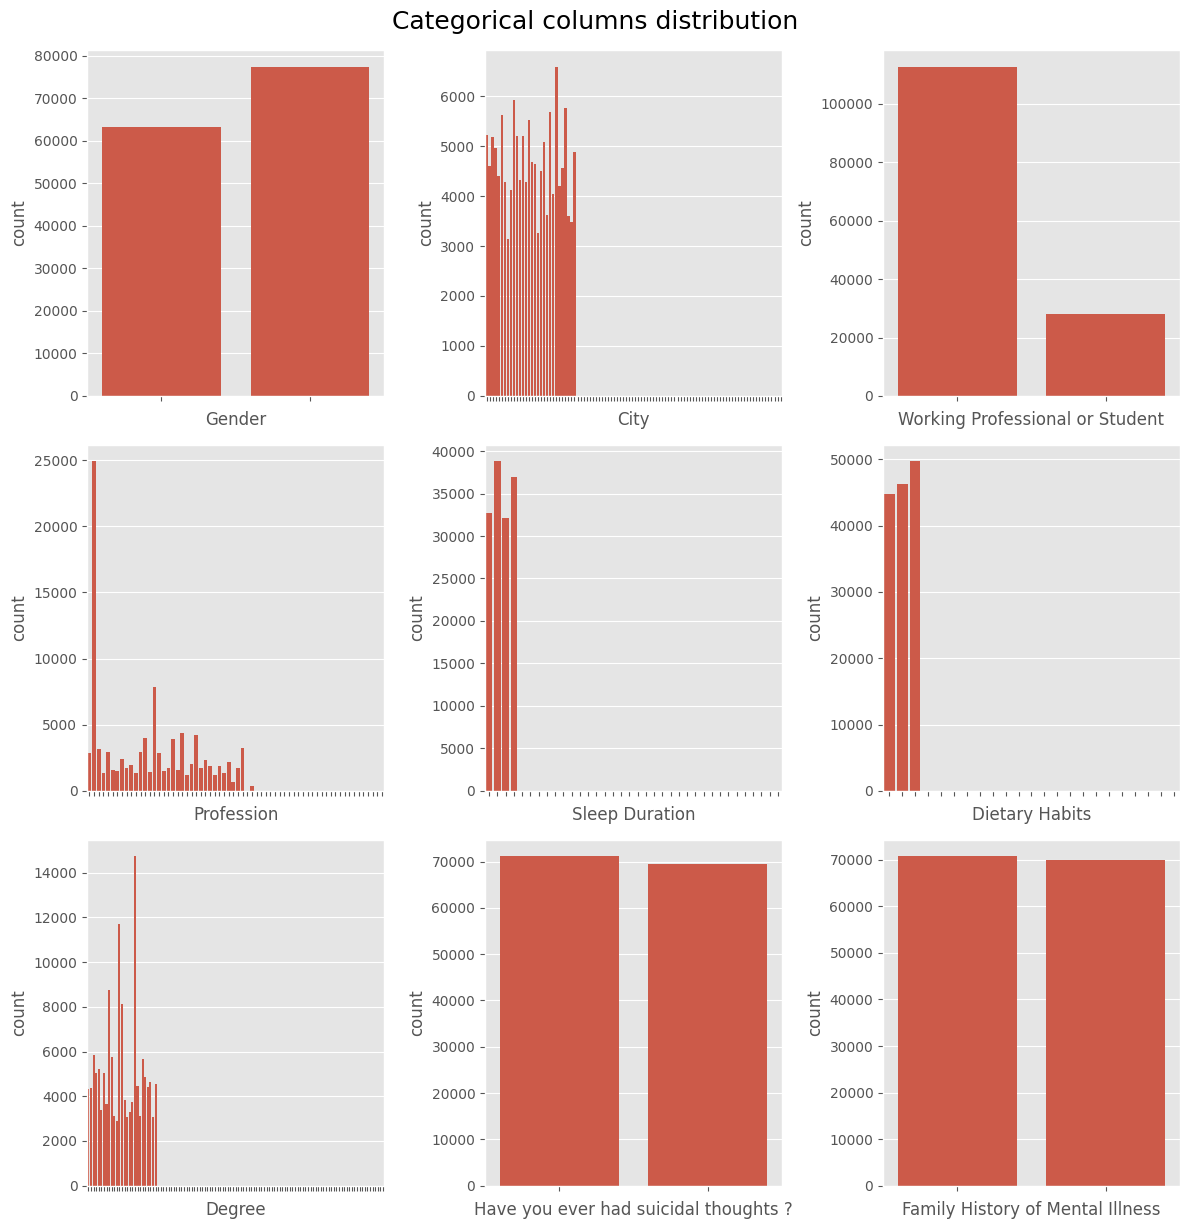

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, col in enumerate(data_categorical_cols):
    plot_categorical_hist(data, col, axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_xticklabels([])

plt.tight_layout()
fig.suptitle('Categorical columns distribution', y=1.02, size=18)
plt.show()

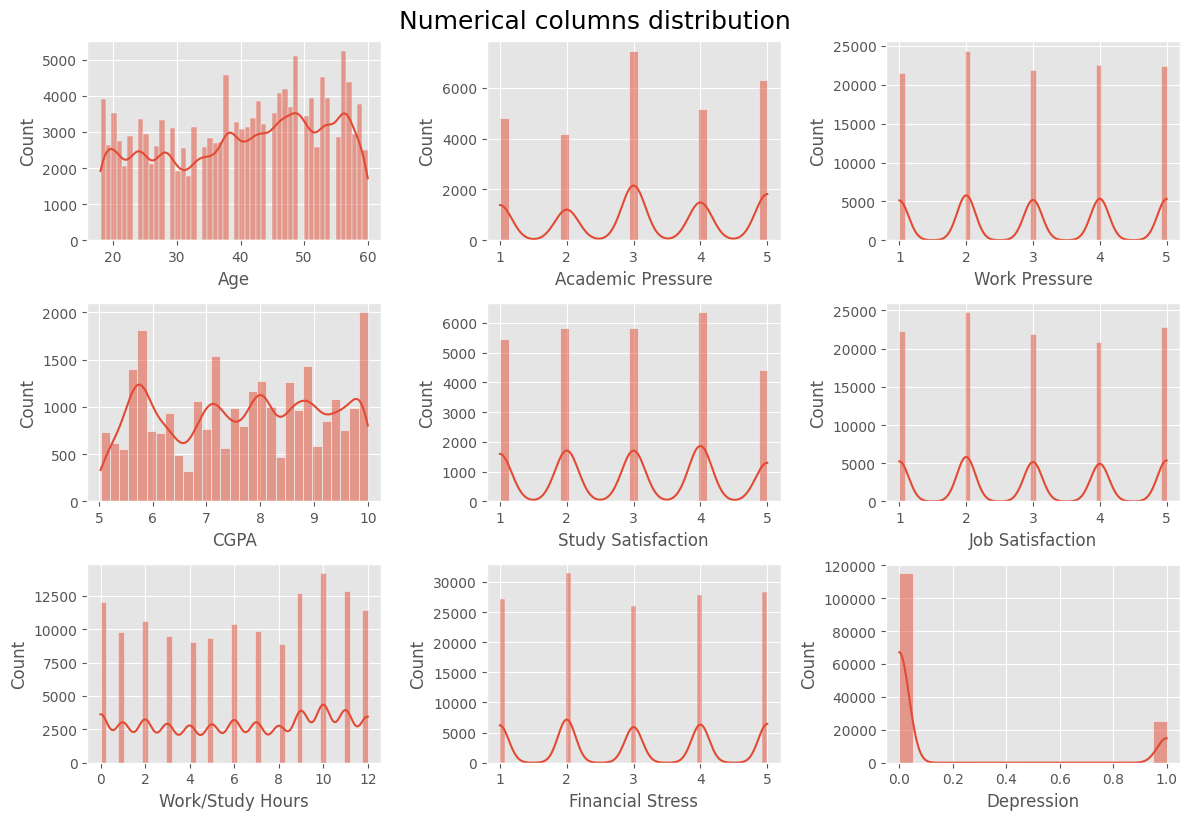

In [49]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for i, col in enumerate(data_numerical_cols):
    plot_numerical_hist(data, col, axes[i // 3, i % 3])

plt.tight_layout()
fig.suptitle('Numerical columns distribution', y=1.02, size=18)
plt.show()

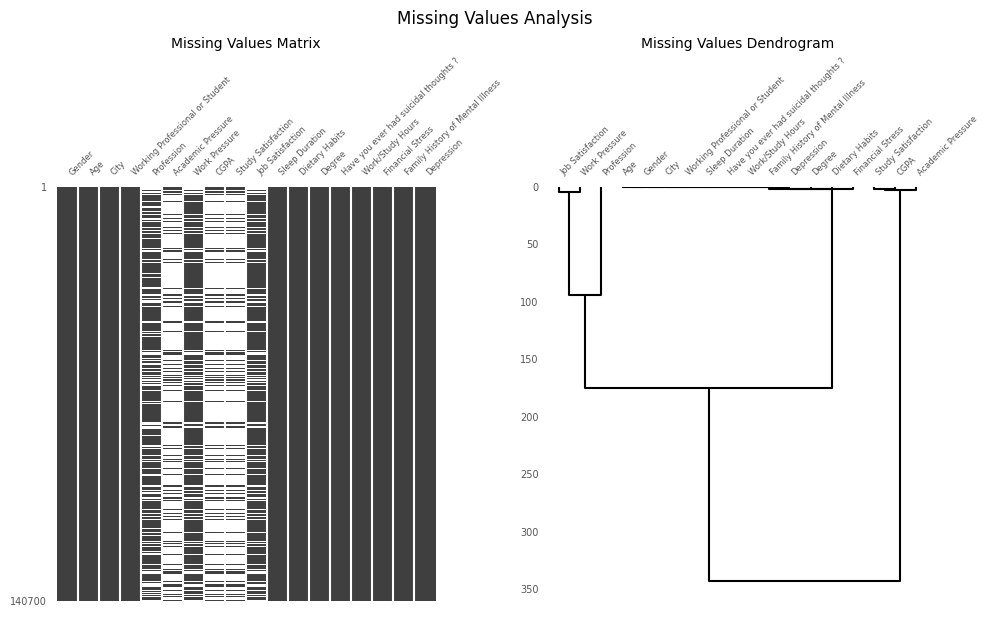

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

plt.sca(axes[0])
msno.matrix(data, sparkline=False, ax=axes[0], fontsize=6)
axes[0].set_title('Missing Values Matrix', fontsize=10)

plt.sca(axes[1])
msno.dendrogram(data, ax=axes[1], fontsize=6)
axes[1].set_title('Missing Values Dendrogram', fontsize=10)

plt.tight_layout()
fig.suptitle('Missing Values Analysis', y=1.02, size=12)
plt.show()

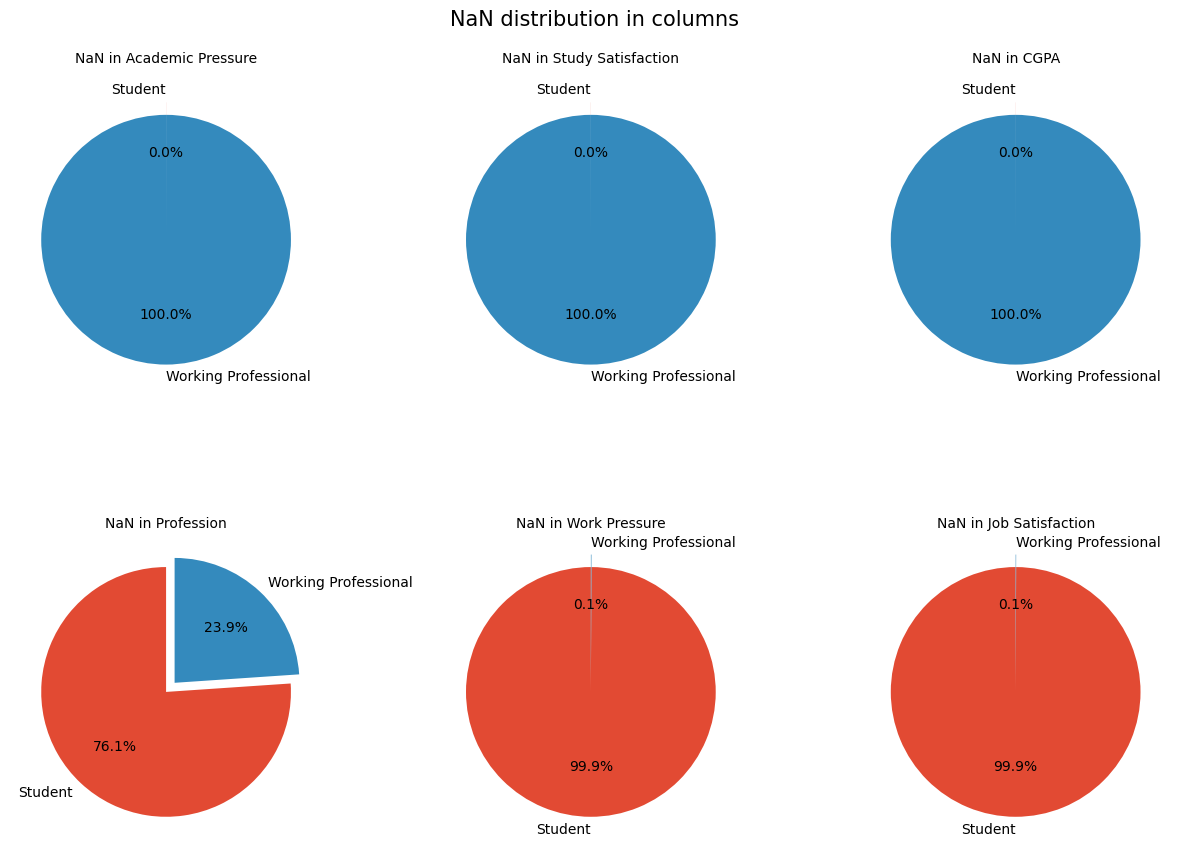

In [97]:
COL_WITH_NA_SORTED = ['Academic Pressure', 'Study Satisfaction', 'CGPA', 'Profession', 'Work Pressure', 'Job Satisfaction']

fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(COL_WITH_NA_SORTED):
    counts = data.groupby('Working Professional or Student')[col].apply(lambda x: x.isna().sum())
    
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, explode=[0, 0.1])
    axes[i].set_title(f'NaN in {col}', fontsize=10)

plt.tight_layout()
fig.suptitle('NaN distribution in columns', y=0.95, size=15)
plt.show()


In [77]:
data_student = data[data['Working Professional or Student'] == 'Student']
data_professional = data[data['Working Professional or Student'] == 'Working Professional']

In [78]:
skim(data_student)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 27901  │ │ string      │ 9     │                                                          │
│ │ Number of columns │ 18     │ │ float64     │ 8     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name           ┃ NA     ┃ NA %   ┃ mean    ┃ sd      ┃ p0    ┃ p25   ┃ p50   ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ Age                   │      0 │      0 │   25.82 │   4.906 │    18 │    21 │    25 │   30 │   59 │  ▇▇▃   │  │
│ │ Academic Pressure     │      9 │   0.03 │   3.142 │   1.381 │     1 │     2 │     3 │    4 │    5 │ ▅▅ ▇▆▇ │  │
│ │ Work Pressure         │  27898 │  99.99 │       4 │   1.732 │     2 │   3.5 │     5 │    5 │    5 │ ▃    ▇ │  │
│ │ CGPA                  │      9 │   0.03 │   7.659 │   1.464 │  5.03 │  6.29 │  7.77 │ 8.92 │   10 │ ▇▅▇▇▇▇ │  │
│ │ Study Satisfaction    │     10 │   0.04 │   2.945 │    1.36 │     1 │     2 │     3 │    4 │    5 │ ▇▇ ▇▇▆ │  │
│ │ Job Satisfaction      │  27893 │  99.97 │   2.375 │   1.188 │     1 │  1.75 │     2 │ 3.25 │    4 │ ▅ ▇ ▃▅ │  │
│ │ Work/Study Hours      │      0 │      0 │   7.157 │   3.708 │     0 │     4 │     8 │   10 │   12 │ ▂▂▂▃▃▇ │  │
│ │ Financial Stress      │      3 │   0.01 │    3.14 │   1.437 │     1 │     2 │     3 │    4 │    5 │ ▆▆ ▆▇▇ │  │
│ │ Depression            │      0 │      0 │  0.5855 │  0.4926 │     0 │     0 │     1 │    1 │    1 │ ▆    ▇ │  │
│ └───────────────────────┴────────┴────────┴─────────┴─────────┴───────┴───────┴───────┴──────┴──────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA         ┃ NA %       ┃ words per row          ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Gender                             │          0 │          0 │                      1 │              27901 │  │
│ │ City                               │          0 │          0 │                      1 │              27905 │  │
│ │ Working Professional or Student    │          0 │          0 │                      1 │              27901 │  │
│ │ Profession                         │      27867 │      99.88 │                 0.0015 │                 42 │  │
│ │ Sleep Duration                     │          0 │          0 │                      3 │              84509 │  │
│ │ Dietary Habits                     │          2 │       0.01 │                      1 │              27903 │  │
│ │ Degree                             │          0 │          0 │                    1.2 │              33983 │  │
│ │ Have you ever had suicidal         │          0 │   

In [80]:
data_student = data_student.drop(['Work Pressure', 'Job Satisfaction', 'Profession'], axis=1)

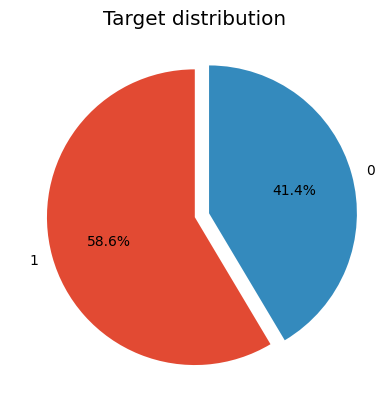

In [127]:
plot_target_distribution(data_student, TARGET_COL)

In [86]:
TOTAL_NA_OVER_AXIS_0 = data_student.isna().sum(axis=0)

print(f'Proportion of missing values in the student dataset: {TOTAL_NA_OVER_AXIS_0.sum() / data_student.shape[0]:5f}')

Proportion of missing values in the student dataset: 0.001183


In [87]:
data_student = data_student.dropna()

In [94]:
X_student = data_student.drop(TARGET_COL, axis=1)
y_student = data_student[TARGET_COL]

In [96]:
print("Student dataset shape:", X_student.shape)
print("Student target shape:", y_student.shape)

Student dataset shape: (27882, 14)
Student target shape: (27882,)


In [108]:
def plot_categorical_count(df: pd.DataFrame,
                           ax: plt.Axes) -> None:
     """
     Plot the count of categories in each categorical column in a specific axis.
    
     :param df: The dataframe to plot.
     :param ax: The axis to plot the histogram.
     """
    
     counts = df.select_dtypes(include='object').nunique().sort_values(ascending=False)
     sns.barplot(x=counts, y=counts.index, ax=ax)
     ax.set_ylabel('')
     ax.set_xlabel('')
     ax.set_title('Number of categories per column')

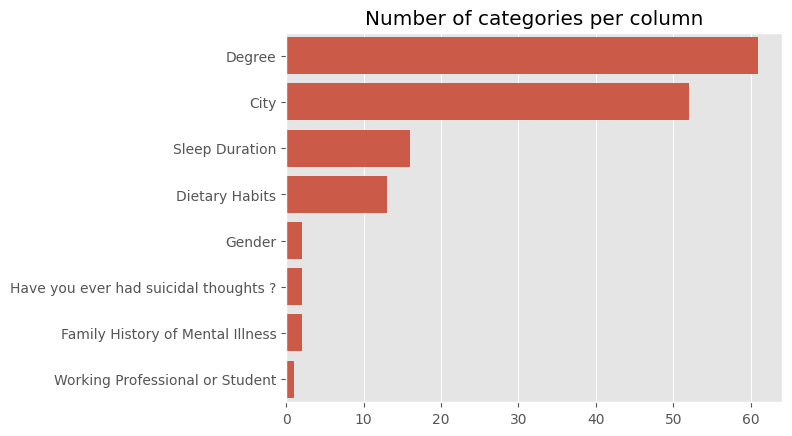

In [109]:
plot_categorical_count(X_student, plt.gca())
plt.show()

In [115]:
print(f"Sleep Duration categories: \n\n{X_student['Sleep Duration'].unique()}", end='\n\n')
print(f"Dietary Habits categories: \n\n{X_student['Dietary Habits'].unique()}")

Sleep Duration categories: 

['5-6 hours' 'Less than 5 hours' '7-8 hours' 'More than 8 hours'
 '1-2 hours' '10-11 hours' '40-45 hours' '2-3 hours' 'Moderate'
 '55-66 hours' '3-4 hours' '4-5 hours' '8 hours' '45' 'than 5 hours'
 '6-7 hours']

Dietary Habits categories: 

['Healthy' 'Moderate' 'Unhealthy' '3' 'Less than Healthy' 'Mihir' '1.0'
 'No Healthy' 'Less Healthy' 'M.Tech' 'Male' 'Yes' '2']


In [120]:
def clean_sleep_diet(X: pd.DataFrame, 
                     seed: int = 42) -> pd.DataFrame:
    """
    Clean the 'Sleep Duration' and 'Dietary Habits' columns.

    :param X: The dataframe to clean.
    :param seed: The random seed to use.
    :return: The cleaned dataframe.
    """

    np.random.seed(seed)

    X = X.copy()

    X['Sleep Duration'] = X['Sleep Duration'].progress_apply(
        lambda value: (
            0 if value in ["Less than 5 hours", "2-3 hours", "3-4 hours", "4-5 hours", "No"]
            else 1 if value in ["5-6 hours", "6-7 hours", "4-6 hours"]
            else 2 if value in ["7-8 hours"]
            else 3 if value in ["8-9 hours", "More than 8 hours", "9-11 hours", "10-11 hours"]
            else np.random.choice([0, 1, 2, 3])
        )
    )

    X['Dietary Habits'] = X['Dietary Habits'].progress_apply(
        lambda value: (
            0 if value in ["Unhealthy", "No Healthy", "No", "1", 1]
            else 1 if value in ["Moderate", "Less Healthy", "Less than Healthy", "2", 2]
            else 2 if value in ["Healthy", "More Healthy", "Yes", "3", 3]
            else np.random.choice([0, 1, 2])
        )
    )

    return X


In [135]:
X_student_cleaned = clean_sleep_diet(X_student)

  0%|          | 0/27882 [00:00<?, ?it/s]

  0%|          | 0/27882 [00:00<?, ?it/s]

In [140]:
X_student_cleaned.head()

,Gender,Age,City,Working Professional or Student,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
2,Male,33.0,Visakhapatnam,Student,5.0,8.97,2.0,1,2,B.Pharm,Yes,3.0,1.0,No
8,Female,24.0,Bangalore,Student,2.0,5.90,5.0,1,1,BSc,No,3.0,2.0,Yes
26,Male,31.0,Srinagar,Student,3.0,7.03,5.0,0,2,BA,No,9.0,1.0,Yes
30,Female,28.0,Varanasi,Student,3.0,5.59,2.0,2,1,BCA,Yes,4.0,5.0,Yes
32,Female,25.0,Jaipur,Student,4.0,8.13,3.0,1,1,M.Tech,Yes,1.0,1.0,No


In [141]:
print("Student dataset shape after PCA:", X_student_cleaned.shape)

Student dataset shape after PCA: (27882, 14)


In [148]:
basic_column_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=0.05),
     X_student_cleaned.select_dtypes(include='object').columns),
    remainder='passthrough',
    sparse_threshold=0
)

pca_pipeline = make_pipeline(
    basic_column_transformer,
    StandardScaler(),
    PCA(random_state=42)
)


X_student_pca = pca_pipeline.fit_transform(X_student_cleaned)


In [149]:
print("Student dataset shape after PCA:", X_student_pca.shape)

Student dataset shape after PCA: (27882, 17)


In [187]:
def plot_corr_matrix_encoded_data(pipeline: Pipeline,
                                  X: pd.DataFrame,
                                  ax: plt.Axes = None) -> pd.DataFrame:
    """
    Plot the correlation matrix of the encoded data.

    :param pipeline: The pipeline to use (must include preprocessing steps).
    :param X: The data to use.
    :param ax: The axis on which to plot the heatmap (optional).
    :return: The correlation matrix.
    """

    preprocessor = pipeline.named_steps['columntransformer']
    encoded_data = preprocessor.fit_transform(X)
    encoder_feature_names = preprocessor.named_transformers_['onehotencoder'].get_feature_names_out(
        X.select_dtypes(include='object').columns
    )
    all_feature_names = list(encoder_feature_names) + list(X.select_dtypes(exclude='object').columns)
    encoded_df = pd.DataFrame(encoded_data, columns=all_feature_names)
    corr_matrix = encoded_df.corr()

    if ax is None:
        _, ax = plt.subplots(figsize=(12, 10))

    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, cbar=True, ax=ax)
    ax.set_title('Correlation Matrix of Encoded Data', fontsize=14)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    return corr_matrix

In [188]:
def plot_corr_matrix_pca(pipeline: Pipeline,
                         X: pd.DataFrame,
                         ax: plt.Axes = None) -> pd.DataFrame:
    """
    Plot the correlation matrix of the PCA-transformed data.

    :param pipeline: The pipeline to use (must include PCA).
    :param X: The data to use.
    :param ax: The axis on which to plot the heatmap (optional).
    :return: The correlation matrix.
    """

    X_pca = pipeline.fit_transform(X)
    pca_model = pipeline.named_steps['pca']
    n_components = pca_model.n_components_
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(X_pca, columns=pca_columns)
    corr_matrix_pca = pca_df.corr()

    if ax is None:
        _, ax = plt.subplots(figsize=(12, 10))

    sns.heatmap(corr_matrix_pca, annot=False, cmap='coolwarm', center=0, cbar=True, ax=ax)
    ax.set_title('Correlation Matrix in PCA Space', fontsize=14)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    return corr_matrix_pca

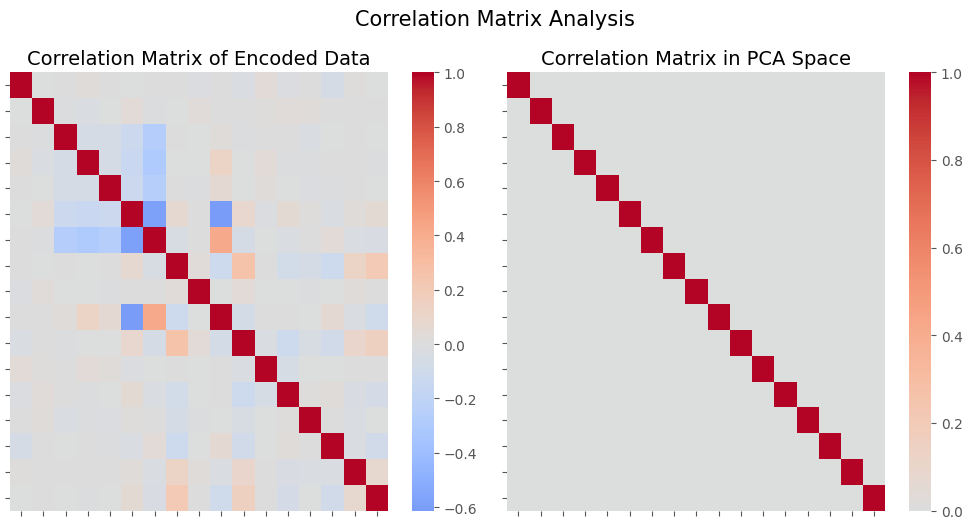

In [195]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

encoded_corr_matrix = plot_corr_matrix_encoded_data(pca_pipeline, X_student_cleaned, ax=axes[0])

pca_corr_matrix = plot_corr_matrix_pca(pca_pipeline, X_student_cleaned, ax=axes[1])

plt.tight_layout()
fig.suptitle('Correlation Matrix Analysis', y=1.05, size=15)
plt.show()

In [169]:
def plot_pca_analysis(pipeline: Pipeline,
                      X: pd.DataFrame,
                      y: pd.Series = None) -> None:
    """
    Plot the PCA analysis.

    :param pipeline: The pipeline to use.
    :param X: The features.
    :param y: The target.
    """

    X_pca = pipeline.fit_transform(X)
    
    pca_model = pipeline.named_steps['pca']
    components = pca_model.components_
    explained_variance = pca_model.explained_variance_ratio_
    
    preprocessor = pipeline.named_steps['columntransformer']
    encoder_feature_names = preprocessor.named_transformers_['onehotencoder'].get_feature_names_out(
        X.select_dtypes(include='object').columns
    )
    all_feature_names = list(encoder_feature_names) + list(X.select_dtypes(exclude='object').columns)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].hexbin(X_pca[:, 0], X_pca[:, 1], C=y, cmap='coolwarm', gridsize=50, alpha=0.5)
    axes[0].set_title('PCA Projection', fontsize=12)
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')
    if y is not None:
        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm'), ax=axes[0])
        cbar.set_label('Target')
    
    axes[1].axhline(0, color='grey', linestyle='--', linewidth=0.5)
    axes[1].axvline(0, color='grey', linestyle='--', linewidth=0.5)
    circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--', linewidth=1.5)
    axes[1].add_artist(circle)
    for i, (x, y) in enumerate(zip(components[0], components[1])):
        axes[1].arrow(0, 0, x, y, color='r', alpha=0.8, head_width=0.03, length_includes_head=True)
        axes[1].text(x * 1.15, y * 1.15, all_feature_names[i], color='blue', fontsize=8, ha='center', va='center')
    axes[1].set_xlim(-1.2, 1.2)
    axes[1].set_ylim(-1.2, 1.2)
    axes[1].set_title('PCA Compas', fontsize=12)
    axes[1].set_xlabel('Principal Component 1')
    axes[1].set_ylabel('Principal Component 2')
    
    axes[2].bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Explained Variance')
    axes[2].step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Variance')
    axes[2].set_title('PCA Explained Variance', fontsize=12)
    axes[2].set_xlabel('Components')
    axes[2].set_ylabel('Variance Ratio')
    axes[2].legend(loc='best')
    
    plt.tight_layout()
    fig.suptitle('PCA Analysis', y=1.02, size=15)
    plt.show()

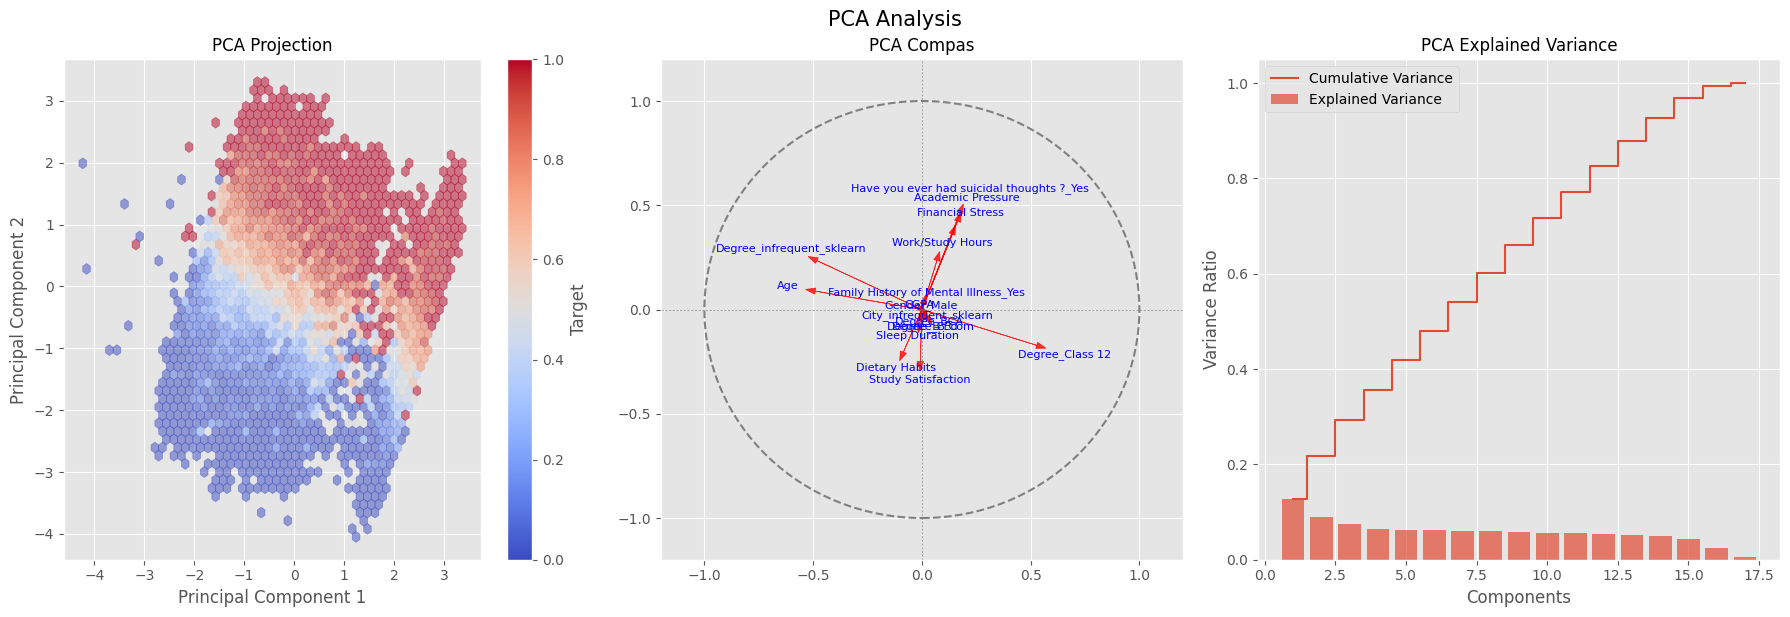

In [168]:
plot_pca_analysis(pca_pipeline, X_student_cleaned, y_student)

In [214]:
def plot_learning_curves(X: pd.DataFrame,
                         y: pd.Series) -> None:
    """
    Plot learning curves for multiple models.
    :param X: Feature DataFrame.
    :param y: Target Series.
    """

    models = {
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(eval_metric="logloss", use_label_encoder=False, verbosity=0),
        'Logistic Regression': LogisticRegression(),
        'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True)
    }

    column_transformer = ColumnTransformer(
        [('encoder', OneHotEncoder(drop='first', max_categories=10, handle_unknown="ignore"),
          X.select_dtypes(include='object').columns)],
        remainder='passthrough',
        sparse_threshold=0
    )

    pipelines = {
        'Random Forest': make_pipeline(column_transformer, models['Random Forest']),
        'XGBoost': make_pipeline(column_transformer, models['XGBoost']),
        'Logistic Regression': make_pipeline(column_transformer, StandardScaler(),
                                             PCA(), models['Logistic Regression']),
        'SVM (RBF Kernel)': make_pipeline(column_transformer, StandardScaler(),
                                          PCA(), models['SVM (RBF Kernel)'])
    }

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, (model_name, pipeline) in enumerate(tqdm(pipelines.items(), desc='Computing Learning Curves')):
        train_sizes, train_scores, val_scores = learning_curve(
            pipeline, X, y, cv=5, scoring='matthews_corrcoef', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
        val_scores_std = np.std(val_scores, axis=1)

        ax = axes[idx]
        ax.set_title(f'Learning Curve - {model_name}', fontsize=12)
        ax.set_xlabel("Training size")
        ax.set_ylabel("Score")
        ax.grid()

        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1, color="r")
        ax.fill_between(train_sizes,
                        val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std,
                        alpha=0.1, color="g")
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training MCC")
        ax.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation MCC")

        ax.legend(loc="best")

    plt.tight_layout()
    fig.suptitle('Learning Curves', y=1.02, size=15)
    plt.show()

Computing Learning Curves:   0%|          | 0/4 [00:00<?, ?it/s]

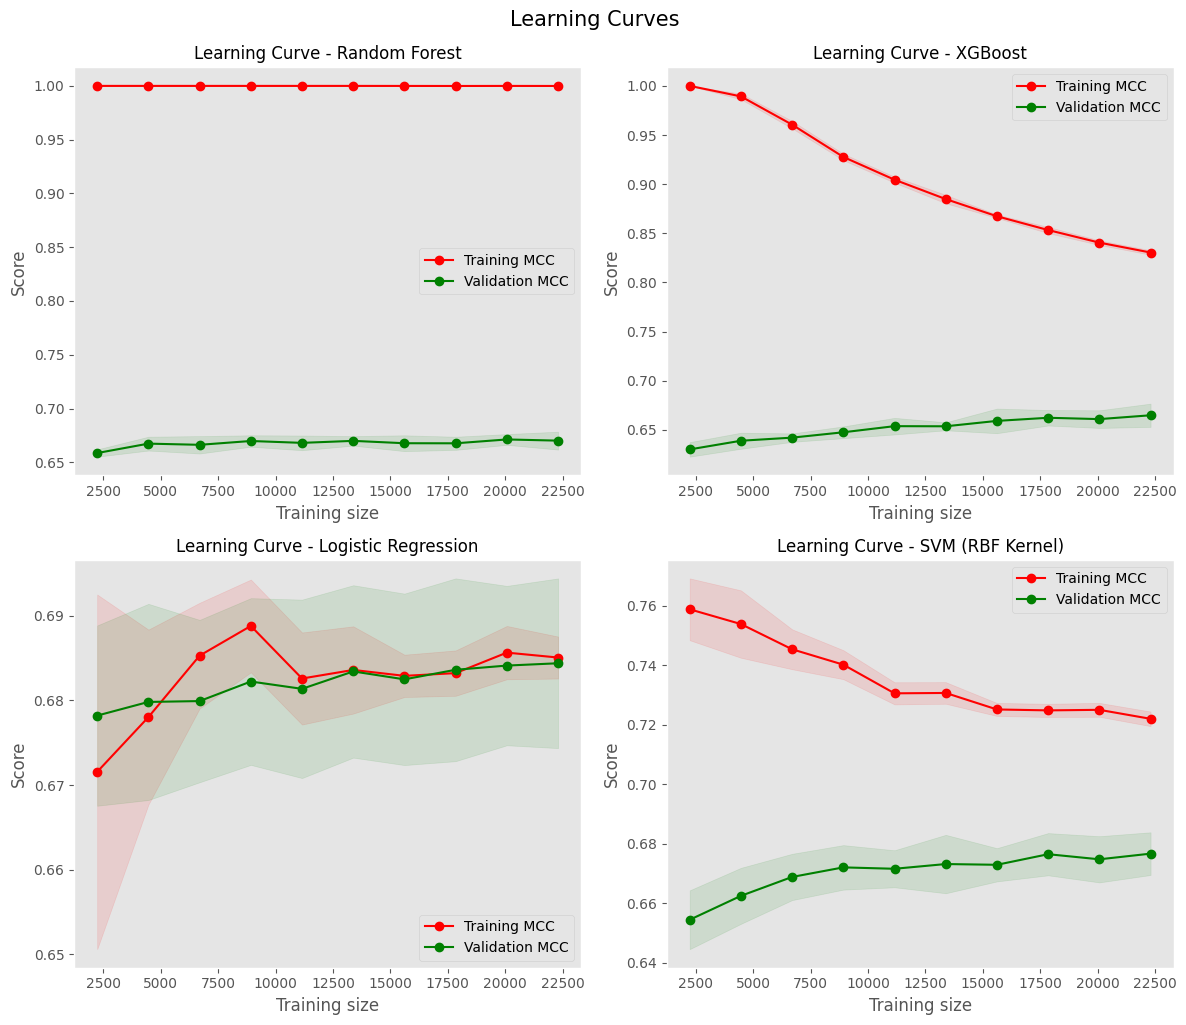

In [215]:
plot_learning_curves(X_student_cleaned, y_student)

In [224]:
def optimize_pca_components(X: pd.DataFrame,
                            y: pd.Series,
                            model: BaseEstimator,
                            min_frequency: float = 0.05,
                            max_components: int = None,
                            cv: int = 5) -> Tuple[int, float,
                                           Dict[int, Tuple[float, float, float, float]]]:
    """
    Optimize the number of components for PCA in a pipeline with a given model using MCC.

    :param X: Feature DataFrame.
    :param y: Target Series.
    :param model: Estimator to use in the pipeline.
    :param min_frequency: Minimum frequency parameter for OneHotEncoder.
    :param max_components: Maximum number of PCA components to test (default: number of features in X).
    :param cv: Number of cross-validation folds (default: 5).
    :return: Tuple of (best_n_components, best_score, scores_dict).
    """

    if max_components is None:
        max_components = X.shape[1]

    column_transformer = ColumnTransformer(
        [('encoder', OneHotEncoder(drop='first', min_frequency=min_frequency, handle_unknown="ignore"),
          X.select_dtypes(include='object').columns)],
        remainder='passthrough',
        sparse_threshold=0
    )

    scores = {}
    train_mean_scores = []
    train_std_scores = []
    val_mean_scores = []
    val_std_scores = []

    for n_components in tqdm(range(1, max_components + 1), desc='Optimizing PCA Components'):
        pipeline = Pipeline([
            ('preprocessor', column_transformer),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_components)),
            ('model', model)
        ])
        cv_results = cross_validate(pipeline, X, y, cv=cv, scoring="matthews_corrcoef", return_train_score=True, n_jobs=-1)
        train_scores = cv_results['train_score']
        val_scores = cv_results['test_score']
        
        train_mean = np.mean(train_scores)
        train_std = np.std(train_scores)
        val_mean = np.mean(val_scores)
        val_std = np.std(val_scores)
        
        train_mean_scores.append(train_mean)
        train_std_scores.append(train_std)
        val_mean_scores.append(val_mean)
        val_std_scores.append(val_std)

        scores[n_components] = (train_mean, train_std, val_mean, val_std)

    best_n_components = max(scores, key=lambda k: scores[k][2])
    best_score = scores[best_n_components][2]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components + 1), train_mean_scores, marker='o', label='Train MCC Score', color='blue')
    plt.fill_between(range(1, max_components + 1),
                     [m - s for m, s in zip(train_mean_scores, train_std_scores)],
                     [m + s for m, s in zip(train_mean_scores, train_std_scores)],
                     color='blue', alpha=0.2)

    plt.plot(range(1, max_components + 1), val_mean_scores, marker='o', label='Validation MCC Score', color='orange')
    plt.fill_between(range(1, max_components + 1),
                     [m - s for m, s in zip(val_mean_scores, val_std_scores)],
                     [m + s for m, s in zip(val_mean_scores, val_std_scores)],
                     color='orange', alpha=0.2)

    plt.xlabel('Number of PCA Components')
    plt.ylabel('MCC Score')
    plt.title('Optimization of PCA Components using MCC')
    plt.grid()
    plt.legend(loc='best')
    plt.show()

    return best_n_components, best_score, scores

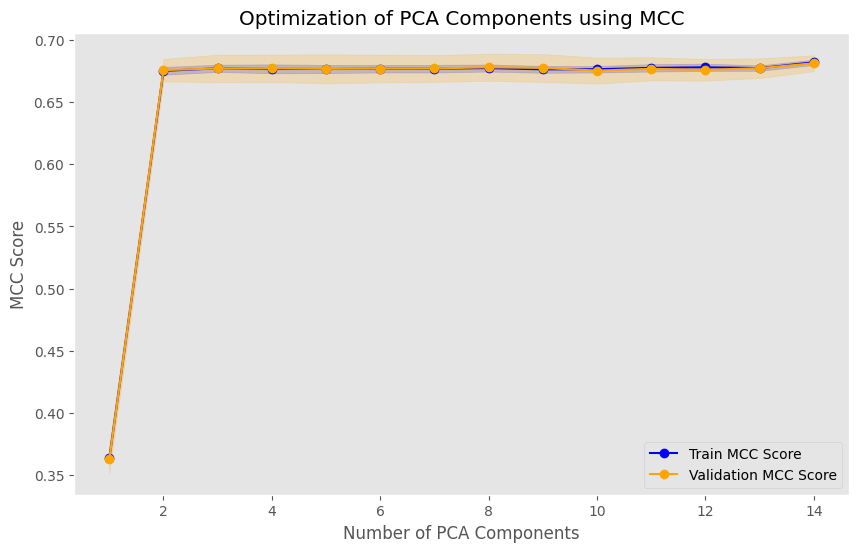

In [226]:
_ = optimize_pca_components(X_student_cleaned, y_student, LogisticRegression(), min_frequency=0.05)

In [252]:
def optimize_pca_and_encoder(X: pd.DataFrame,
                             y: pd.Series,
                             model: BaseEstimator, 
                             min_frequency_range: np.ndarray = np.linspace(0.01, 0.5, 10),
                             max_components: int = None,
                             cv: int = 5) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Optimize both n_components for PCA and min_frequency for OneHotEncoder with a given model using MCC.
    Displays a contour plot of MCC scores.

    :param X: Feature DataFrame.
    :param y: Target Series.
    :param model: Estimator to use in the pipeline.
    :param min_frequency_range: Range of min_frequency values to test (default: np.linspace(0.01, 0.5, 10)).
    :param max_components: Maximum number of PCA components to test (default: 1 to number of features in X).
    :param cv: Number of cross-validation folds (default: 5).
    :return: Tuple of (min_frequency_values, n_components_values, scores_grid).
    """

    if max_components is None:
        max_components = min(X.shape[1], X.shape[0] * (cv - 1) // cv)

    n_components_range = range(1, max_components + 1)
    scores_grid = []

    for min_frequency in tqdm(min_frequency_range, desc='Optimizing PCA and Encoder'):
        row_scores = []
        for n_components in n_components_range:
            column_transformer = ColumnTransformer(
                [('encoder', OneHotEncoder(drop='first', min_frequency=min_frequency, handle_unknown="ignore"),
                  X.select_dtypes(include='object').columns)],
                remainder='passthrough',
                sparse_threshold=0
            )
            pipeline = Pipeline([
                ('preprocessor', column_transformer),
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_components)),
                ('model', model)
            ])
            try:
                score = np.mean(cross_val_score(pipeline, X, y, cv=cv, scoring="matthews_corrcoef", n_jobs=-1))
                row_scores.append(score)
            except ValueError:
                row_scores.append(np.nan)
        scores_grid.append(row_scores)

    min_frequency_values = np.array(min_frequency_range)
    n_components_values = np.array(list(n_components_range))
    scores_grid = np.array(scores_grid)

    X_mesh, Y_mesh = np.meshgrid(n_components_values, min_frequency_values)

    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X_mesh, Y_mesh, scores_grid, levels=50, cmap='viridis_r', alpha=0.8)
    plt.colorbar(contour, label="MCC Score")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Min Frequency (OneHotEncoder)")
    plt.title("Optimization of n_components and min_frequency (MCC)")
    plt.show()

    return min_frequency_values, n_components_values, scores_grid

Optimizing PCA and Encoder:   0%|          | 0/12 [00:00<?, ?it/s]

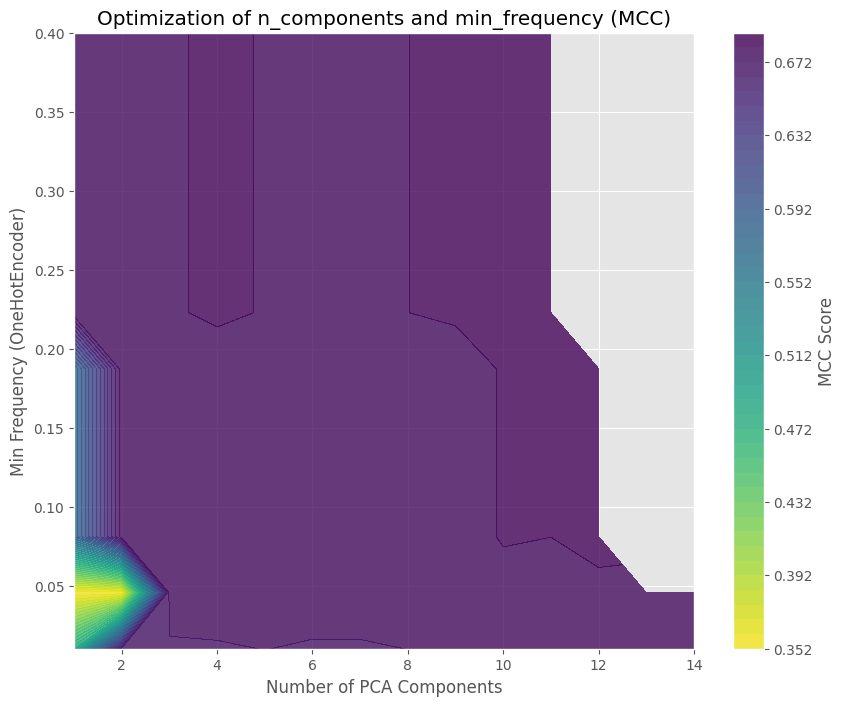

In [253]:
_ = optimize_pca_and_encoder(X_student_cleaned, y_student, LogisticRegression(), min_frequency_range=np.linspace(0.01, 0.4, 12))